In [57]:
#load python packages
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy as scipy
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split, KFold
import collections
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn import model_selection
from sklearn.metrics import accuracy_score,mean_squared_error,mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import linear_model, preprocessing
import statsmodels.api as sm
from sklearn import tree, metrics
%matplotlib inline

In [2]:
#Read in json file
file = '/Users/Sue/Documents/2020_study/springboard/take_home_challenge/ultimate_challenge/logins.json'
data = pd.read_json(file)
df = pd.DataFrame(data)
print(df.head(5))

           login_time
0 1970-01-01 20:13:18
1 1970-01-01 20:16:10
2 1970-01-01 20:16:37
3 1970-01-01 20:16:36
4 1970-01-01 20:26:21


In [3]:
df.dtypes

login_time    datetime64[ns]
dtype: object

In [4]:
df = df.set_index('login_time')

In [5]:
df['count']=1

In [6]:
df_resample = df.resample("15T").agg({'count':'sum'})

In [7]:
df_resample.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


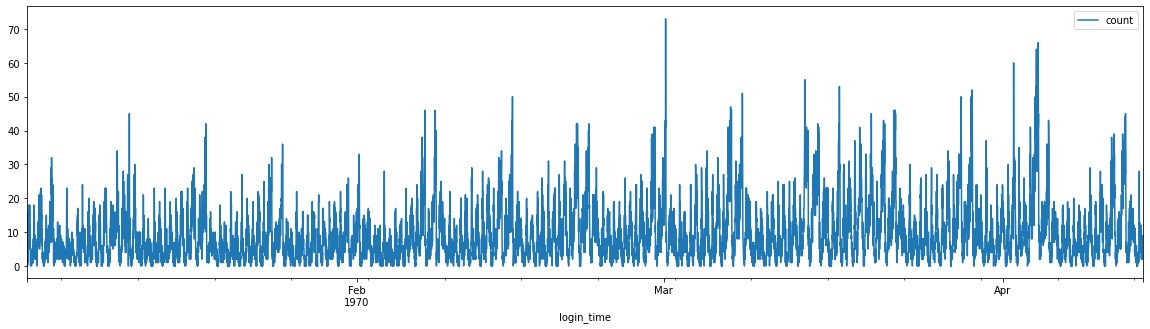

In [8]:
df_resample.plot(kind='line',figsize=(20,5))

In [9]:
df_resample['envelope'] = scipy.ndimage.filters.maximum_filter1d(df_resample['count'], 130)
df_resample.head()

,count,envelope
login_time,,
1970-01-01 20:00:00,2,18
1970-01-01 20:15:00,6,18
1970-01-01 20:30:00,9,18
1970-01-01 20:45:00,7,18
1970-01-01 21:00:00,1,18


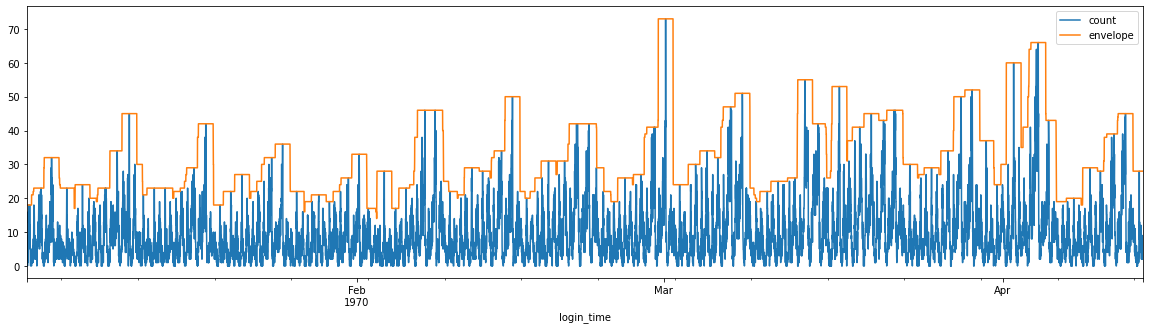

In [10]:
df_resample.plot(kind='line',figsize=(20,5))

In [11]:
df_resample.reset_index(inplace = True)


In [12]:
df_resample

,login_time,count,envelope
0,1970-01-01 20:00:00,2,18
1,1970-01-01 20:15:00,6,18
2,1970-01-01 20:30:00,9,18
3,1970-01-01 20:45:00,7,18
4,1970-01-01 21:00:00,1,18
...,...,...,...
9783,1970-04-13 17:45:00,5,28
9784,1970-04-13 18:00:00,5,28
9785,1970-04-13 18:15:00,2,28
9786,1970-04-13 18:30:00,7,28


In [13]:
# extract day, week, hour information from login_time

In [14]:
df_resample["hour"] = df_resample["login_time"].dt.hour
df_resample["month"] = df_resample["login_time"].dt.month
df_resample["date"] = df_resample["login_time"].dt.date
df_resample["day"] = df_resample["login_time"].dt.day_name()

In [15]:
df_resample.head()

,login_time,count,envelope,hour,month,date,day
0,1970-01-01 20:00:00,2,18,20,1,1970-01-01,Thursday
1,1970-01-01 20:15:00,6,18,20,1,1970-01-01,Thursday
2,1970-01-01 20:30:00,9,18,20,1,1970-01-01,Thursday
3,1970-01-01 20:45:00,7,18,20,1,1970-01-01,Thursday
4,1970-01-01 21:00:00,1,18,21,1,1970-01-01,Thursday


In [16]:
#firstly group by date to analyze the login pattern per day

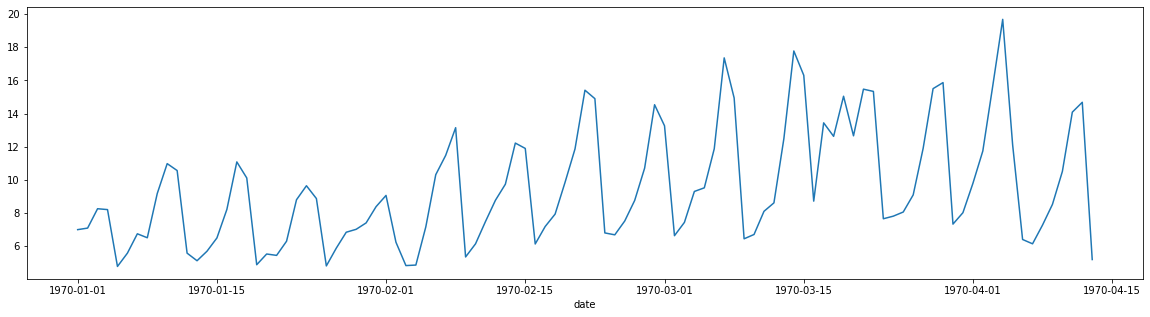

In [17]:
df_date = df_resample.groupby("date").sum()[["count"]]
df_date["avg_date"] = df_resample.groupby("date").mean()[["count"]]
df_date['avg_date'].plot(kind='line',figsize=(20,5))

In [18]:
# The oscillation is during week time. So next will analyze the pattern in a week

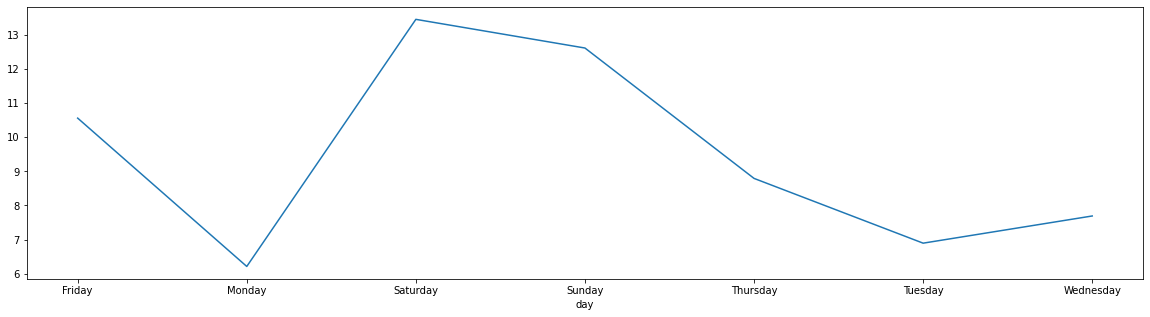

In [19]:
df_day = df_resample.groupby("day").sum()[["count"]]
df_day["avg_week"] = df_resample.groupby("day").mean()[["count"]]
df_day['avg_week'].plot(kind='line',figsize=(20,5))

In [20]:
# most popular login time is during the weekend, from friday to Sunday, the least login is on Monday.
# Next will check general trend by month

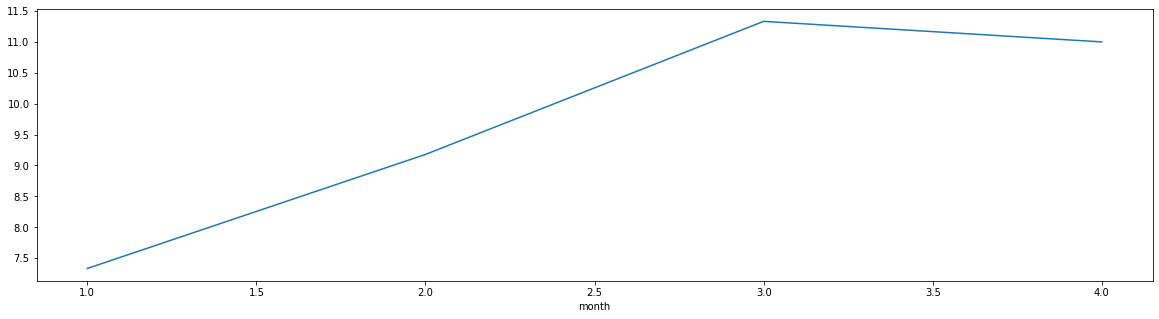

In [21]:
df_month = df_resample.groupby("month").sum()[["count"]]
df_month["avg_month"] = df_resample.groupby("month").mean()[["count"]]
df_month['avg_month'].plot(kind='line',figsize=(20,5))

In [22]:
# more and more visitors since January, and after two months, the trend becomes flat

# what is the popular login time in a day. As we see the difference between weekdays and weekend, we need to analyze the popular login time by differen day

df_hour = df_resample.groupby(["hour", "day"]).mean().reset_index()

f, axes = plt.subplots(figsize=(20,7))
ax = sns.lineplot(x="hour", y="count", data=df_hour, hue="day")
ax.set(title="Daily Logins per Hour")
plt.show()

## Part 2

In order to know if reimbursing the toll costs will encourage the drivers, the main key should be the number of rides from two cities before and after reimbursing the costs. That means the matrics should be -- the number of rides from two cities.

If the number of rides increased, that means reducing the cost encouraged drivers to serve not only one city.
Another metrics can be use is the waiting time of cars with and without reimbursing the costs.

To design the experiment, firstly need a set of data with toll fee in a period of time. Then need another set of data with toll fee reimbursed in the same length time. Then by analyzing the average or median waiting time and the number of rides, and analyze if reimbursing affect the number of rides.

## Part 3

In [23]:
file = '/Users/Sue/Documents/2020_study/springboard/take_home_challenge/ultimate_challenge/ultimate_data_challenge.json'
data = pd.read_json(file)
df = pd.DataFrame(data)
print(df.head(5))

             city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17   iPhone       15.4                 True   
1       1.00     2014-05-05  Android        0.0                False   
2       1.00     2014-01-07   iPhone        0.0                False   
3       1.14     2014-06-29   iPhone       20.0                 True   
4       1.19     2014-03-15  Android       11.8                False   

   weekday_pct  avg_dist  avg_rating_by_driver  
0         46.2      3.67                   

In [24]:

df["last_trip_date"] = pd.to_datetime(df["last_trip_date"])
df["signup_date"] = pd.to_datetime(df["signup_date"])
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [25]:
df.dtypes

city                              object
trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                             object
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
dtype: object

In [26]:

# the target variable means if active in the 6th month, so here define active
df['active']=df['last_trip_date'] - datetime.timedelta(5 * 30)> df['signup_date']
#df["active"] = df["trips_in_first_30_days"].apply(lambda row: 1 if df['last_trip_date'] else 0)
df['active'].value_counts()

False    37802
True     12198
Name: active, dtype: int64

In [27]:
df['active'].value_counts()/df['active'].count()

False    0.75604
True     0.24396
Name: active, dtype: float64

In [28]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [29]:
df.isnull().sum().sort_values(ascending=False)

avg_rating_of_driver      8122
phone                      396
avg_rating_by_driver       201
active                       0
avg_dist                     0
weekday_pct                  0
ultimate_black_user          0
surge_pct                    0
last_trip_date               0
avg_surge                    0
signup_date                  0
trips_in_first_30_days       0
city                         0
dtype: int64

In [30]:
df['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

### Data Cleaning
there are three columns have missing data, avg_rating_of_driver and avg_rating_by_driver, since these two are average value, will replace the missing data with the average of each column.

The phone data that are missing may be neither iphone or Android, so will fill it with 'unknown'

In [31]:
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(value = df['avg_rating_of_driver'].mean())
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(value = df['avg_rating_by_driver'].mean())

In [32]:
df['phone'] = df['phone'].fillna(value ='unknown')

In [33]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,False
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False


### feature engineering
After cleaning up numerical data, we need to deal with text data.
There are three text columns, city, phone, and ultimate_black_user

In [34]:
df['city'].value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

In [35]:
# the city column has 3 unique values, same for phone, will generate dummy columns for these two

In [36]:
pd.get_dummies(df['city'])

,Astapor,King's Landing,Winterfell
0,0,1,0
1,1,0,0
2,1,0,0
3,0,1,0
4,0,0,1
...,...,...,...
49995,0,1,0
49996,1,0,0
49997,0,0,1
49998,1,0,0


In [37]:
columns = ['city','phone']
for column in columns:
    one_hot = pd.get_dummies(df[column])
# Drop column as it is now encoded
    df = df.drop(column,axis = 1)
# Join the encoded df
    df = df.join(one_hot)
    df 

In [38]:
df

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active,Astapor,King's Landing,Winterfell,Android,iPhone,unknown
0,4,2014-01-25,4.700000,1.10,2014-06-17,15.4,True,46.2,3.67,5.0,False,0,1,0,0,1,0
1,0,2014-01-29,5.000000,1.00,2014-05-05,0.0,False,50.0,8.26,5.0,False,1,0,0,1,0,0
2,3,2014-01-06,4.300000,1.00,2014-01-07,0.0,False,100.0,0.77,5.0,False,1,0,0,0,1,0
3,9,2014-01-10,4.600000,1.14,2014-06-29,20.0,True,80.0,2.36,4.9,True,0,1,0,0,1,0
4,14,2014-01-27,4.400000,1.19,2014-03-15,11.8,False,82.4,3.13,4.9,False,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,2014-01-25,5.000000,1.00,2014-06-05,0.0,False,100.0,5.63,4.2,False,0,1,0,0,1,0
49996,1,2014-01-24,4.601559,1.00,2014-01-25,0.0,False,0.0,0.00,4.0,False,1,0,0,0,1,0
49997,0,2014-01-31,5.000000,1.00,2014-05-22,0.0,True,100.0,3.86,5.0,False,0,0,1,1,0,0
49998,2,2014-01-14,3.000000,1.00,2014-01-15,0.0,False,100.0,4.58,3.5,False,1,0,0,0,1,0


In [39]:
df['ultimate_black_user']=df['ultimate_black_user'].astype(int)

In [40]:
df['active']=df['active'].astype(int)

In [41]:
df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active,Astapor,King's Landing,Winterfell,Android,iPhone,unknown
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,1,46.2,3.67,5.0,0,0,1,0,0,1,0
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,0,50.0,8.26,5.0,0,1,0,0,1,0,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,0,100.0,0.77,5.0,0,1,0,0,0,1,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,1,80.0,2.36,4.9,1,0,1,0,0,1,0
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,0,82.4,3.13,4.9,0,0,0,1,1,0,0


### EDA

1. active
2. signup_date
3. avg_rating_by_driver
4. acg_rating_of_driver
5. surge_pct
6. weekday_pct
7. avg_dist


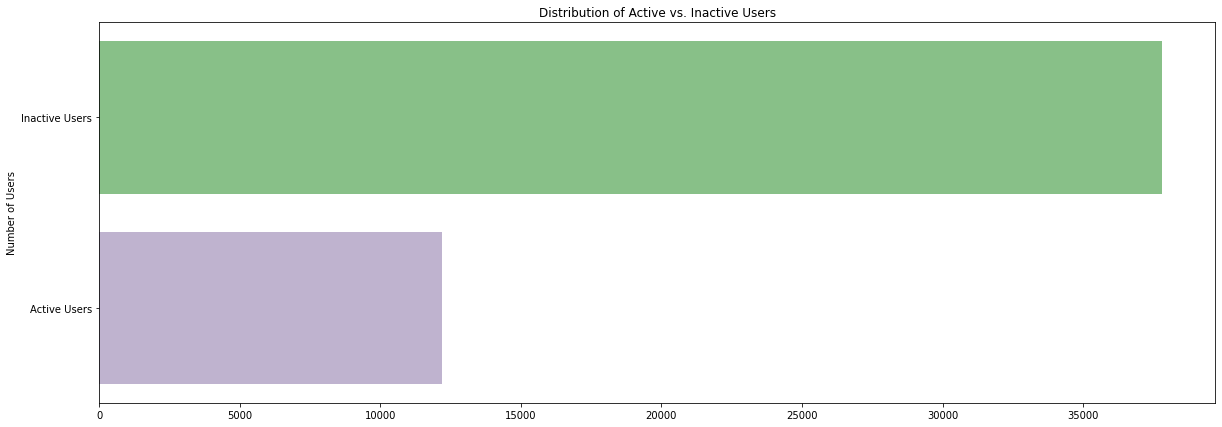

In [42]:
#1. active
f, axes = plt.subplots(figsize=(20,7))
ax = sns.countplot(y=df["active"], palette="Accent")
ax.set(title="Distribution of Active vs. Inactive Users", \
       xlabel="", ylabel="Number of Users")
ax.set_yticklabels(["Inactive Users", "Active Users"])
plt.show()

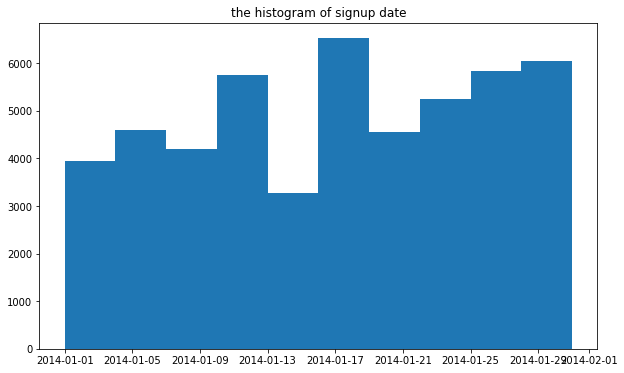

In [43]:
#2. signup date
plt.figure(figsize = (10,6))
plt.hist(df['signup_date'])
plt.title('the histogram of signup date')
plt.show()

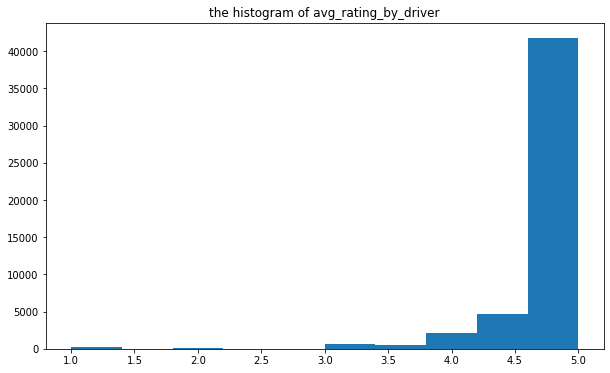

In [44]:
#8. avg_rating_by_driver
plt.figure(figsize = (10,6))
plt.hist(df['avg_rating_by_driver'])
plt.title('the histogram of avg_rating_by_driver')
plt.show()

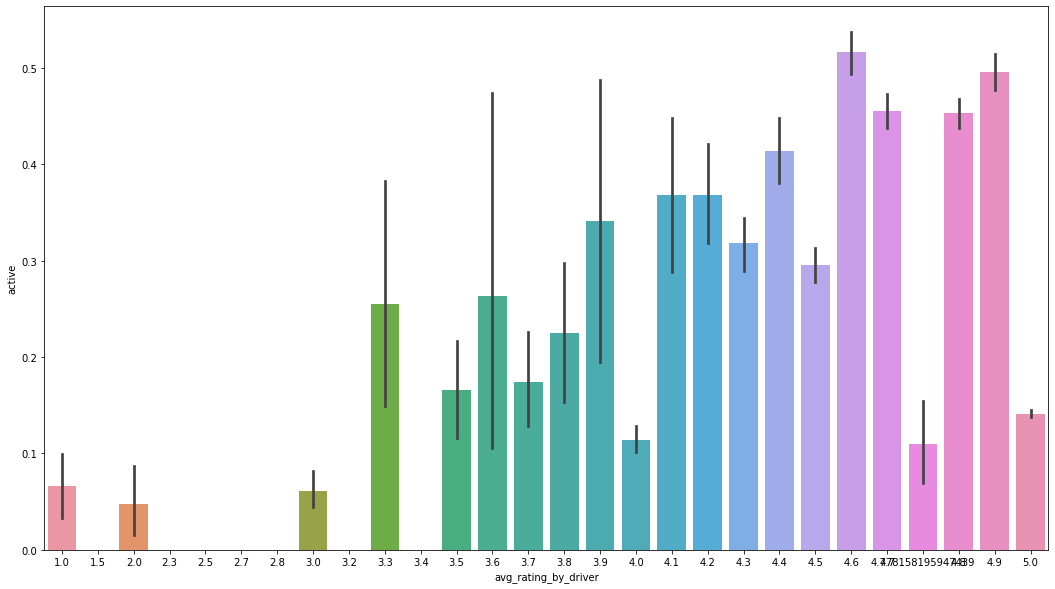

In [45]:
plt.figure(figsize = (18,10))
ax = sns.barplot(x="avg_rating_by_driver", y="active", data=df)

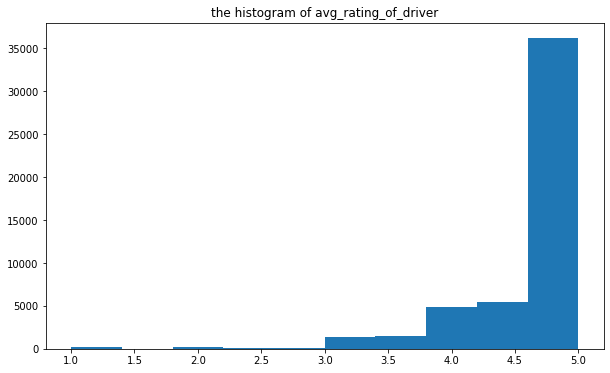

In [46]:
#3. avg_rating_of_driver
plt.figure(figsize = (10,6))
plt.hist(df['avg_rating_of_driver'])
plt.title('the histogram of avg_rating_of_driver')
plt.show()

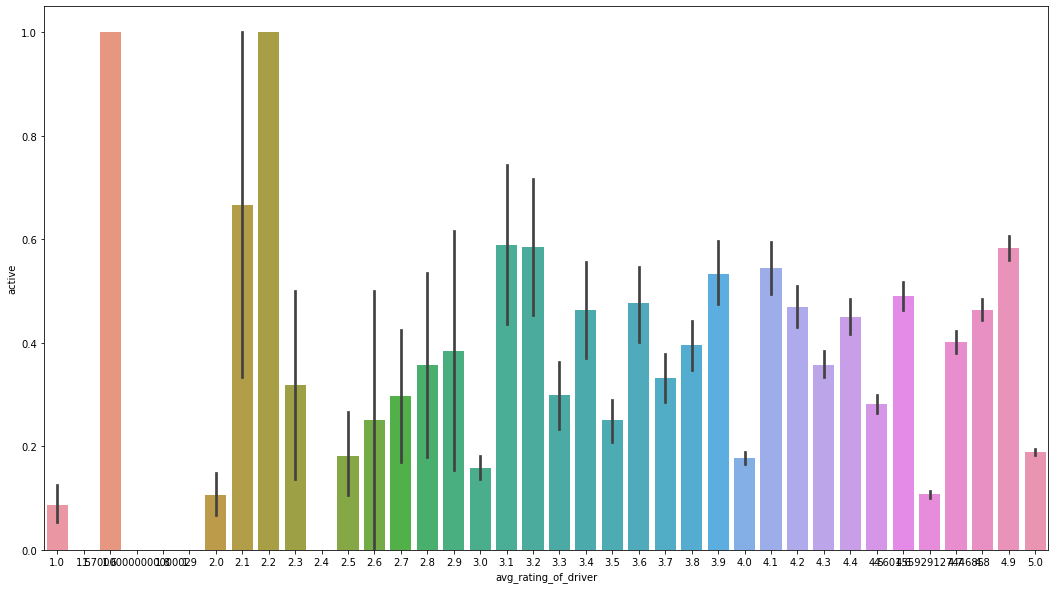

In [47]:
plt.figure(figsize = (18,10))
ax = sns.barplot(x="avg_rating_of_driver", y="active", data=df)

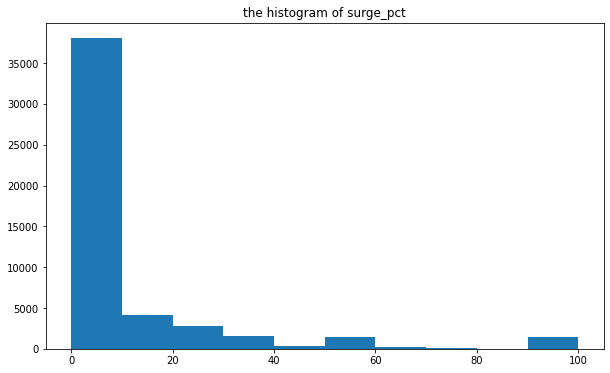

In [48]:
#5. surge_pct
plt.figure(figsize = (10,6))
plt.hist(df['surge_pct'])
plt.title('the histogram of surge_pct')
plt.show()

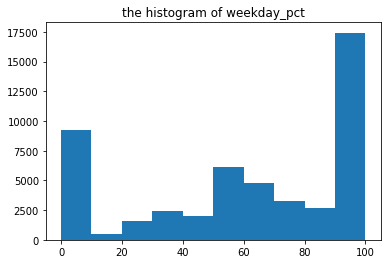

In [49]:
#6. weekday_pct
plt.hist(df['weekday_pct'])
plt.title('the histogram of weekday_pct')
plt.show()

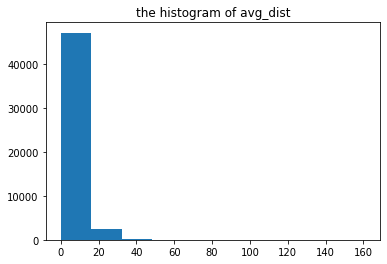

In [50]:
#7. avg_dist
plt.hist(df['avg_dist'])
plt.title('the histogram of avg_dist')
plt.show()

In [51]:
df['signup_date_year']=df['signup_date'].dt.year
df['signup_date_month']=df['signup_date'].dt.month
df['signup_date_day']=df['signup_date'].dt.day
df['signup_date_dayweek']=df['signup_date'].dt.dayofweek
df['last_trip_date_year']=df['last_trip_date'].dt.year
df['last_trip_date_month']=df['last_trip_date'].dt.month
df['last_trip_date_day']=df['last_trip_date'].dt.day
df['last_trip_date_dayweek']=df['last_trip_date'].dt.dayofweek

In [52]:
df = df.drop(['signup_date','last_trip_date'], axis = 1)

In [53]:
df

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active,Astapor,...,iPhone,unknown,signup_date_year,signup_date_month,signup_date_day,signup_date_dayweek,last_trip_date_year,last_trip_date_month,last_trip_date_day,last_trip_date_dayweek
0,4,4.700000,1.10,15.4,1,46.2,3.67,5.0,0,0,...,1,0,2014,1,25,5,2014,6,17,1
1,0,5.000000,1.00,0.0,0,50.0,8.26,5.0,0,1,...,0,0,2014,1,29,2,2014,5,5,0
2,3,4.300000,1.00,0.0,0,100.0,0.77,5.0,0,1,...,1,0,2014,1,6,0,2014,1,7,1
3,9,4.600000,1.14,20.0,1,80.0,2.36,4.9,1,0,...,1,0,2014,1,10,4,2014,6,29,6
4,14,4.400000,1.19,11.8,0,82.4,3.13,4.9,0,0,...,0,0,2014,1,27,0,2014,3,15,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,5.000000,1.00,0.0,0,100.0,5.63,4.2,0,0,...,1,0,2014,1,25,5,2014,6,5,3
49996,1,4.601559,1.00,0.0,0,0.0,0.00,4.0,0,1,...,1,0,2014,1,24,4,2014,1,25,5
49997,0,5.000000,1.00,0.0,1,100.0,3.86,5.0,0,0,...,0,0,2014,1,31,4,2014,5,22,3
49998,2,3.000000,1.00,0.0,0,100.0,4.58,3.5,0,1,...,1,0,2014,1,14,1,2014,1,15,2


### Model building

Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.

In [63]:
#split the data

import statsmodels.api as sm
y = df[['active']]
X = df[df.columns.drop('active')]

#X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=42)

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression()
# Fit the model on the trainng data.
clf.fit(X_train, y_train)
# Print the accuracy from the testing data.
print(accuracy_score(clf.predict(X_test), y_test))

/Users/Sue/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9128


/Users/Sue/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [64]:
model = RandomForestRegressor(max_depth = 8,n_estimators = 10000)
model.fit(X_train, y_train)

fold_importance = pd.DataFrame()
fold_importance["feature"] = X.columns
fold_importance["importance"] = model.feature_importances_

/Users/Sue/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


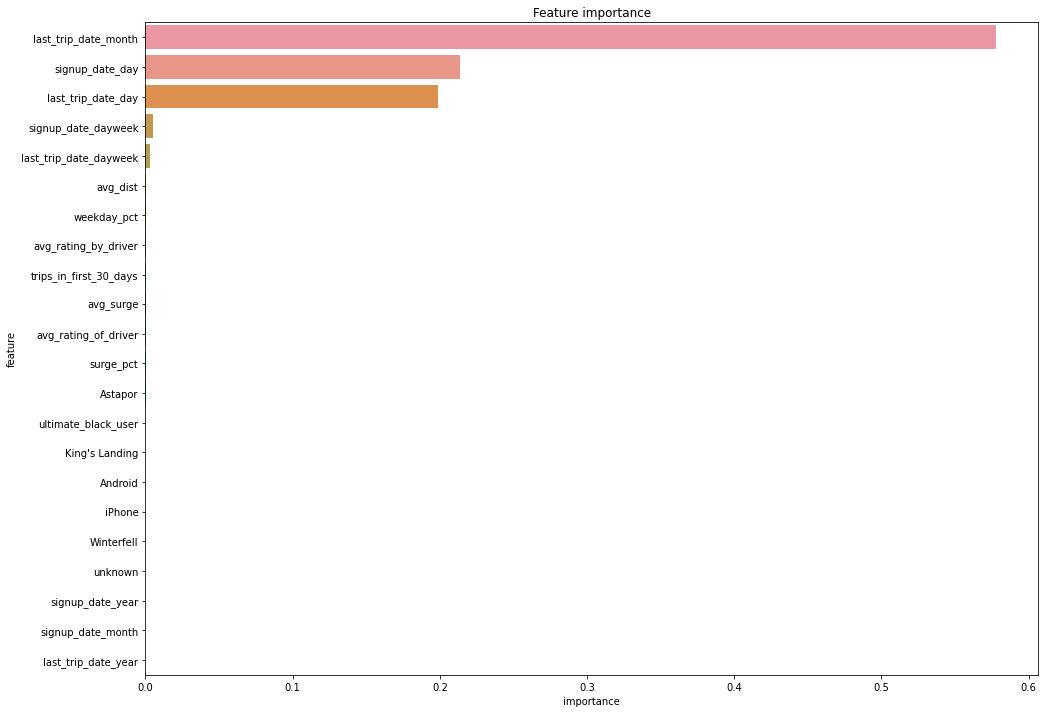

In [65]:
plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=fold_importance.sort_values(by="importance", ascending=False));
plt.title('Feature importance');

In [70]:
fold_importance

,feature,importance
0,trips_in_first_30_days,0.000227
1,avg_rating_of_driver,0.000146
2,avg_surge,0.000150
3,surge_pct,0.000126
4,ultimate_black_user,0.000029
5,weekday_pct,0.000353
6,avg_dist,0.000612
7,avg_rating_by_driver,0.000233
8,Astapor,0.000037
9,King's Landing,0.000019


Text(0.5, 1.0, 'Feature importance')

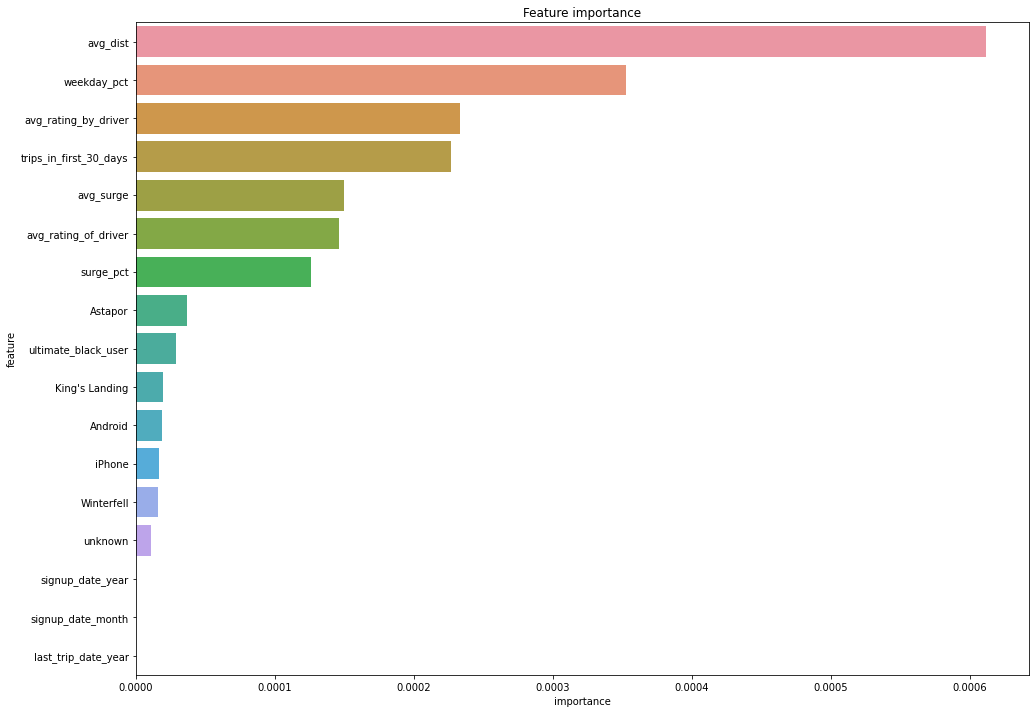

In [71]:
sub_importance = fold_importance.drop([16,17,19,20,21])
plt.figure(figsize=(16, 12))
sns.barplot(x="importance", y="feature", data=sub_importance.sort_values(by="importance", ascending=False))
plt.title('Feature importance')